In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

In [2]:
#color blind colors
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
from DensitiesGenerator import DensityGenerator
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Generation du dict mix Gauss/Laplace

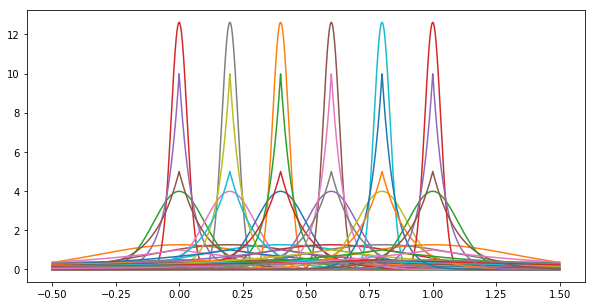

In [22]:
from scipy.stats import multivariate_normal
from scipy.stats import laplace

nodes_gauss = [0, 0.2, 0.4, 0.6, 0.8, 1]
var_list = [1, 10**(-1), 10**(-2), 10**(-3)]
densities = []
for m in nodes_gauss:
    for var in var_list:
        densities.append(multivariate_normal(m, var))
scales =[0.05, 0.1, 0.5, 1]
nodes_lapl = [0, 0.2, 0.4, 0.6, 0.8, 1]

for m in nodes_lapl:
    for scale in scales:
        densities.append(laplace(loc=m, scale=scale))

x = np.linspace(-0.5,1.5,10000)

fig1, ax1 = plt.subplots(figsize=(10,5))
for d in densities:
    plt.plot(x, d.pdf(x))
#ax1.set_yscale('log')

plt.legend(loc='upper right')
plt.savefig("../../phd-thesis/TeX_files/lapl_gauss_dict.png", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

In [6]:
len(densities)

48

In [7]:
#test
selected_densities = [np.random.choice(range(len(densities))) for _ in range(8)]
print selected_densities
print len(densities)
from DensitiesGenerator import DensityGenerator
n_points = 10000
n_pdf = 10000
dg = DensityGenerator()

X, pdf, w, sd = dg.gaussian(100, densities=densities, selected_densities=selected_densities)

[2, 8, 24, 22, 23, 14, 41, 7]
48


# Generation des f*

In [40]:
n_pdf = 10000
N = 1000
dg = DensityGenerator(n_pdf=n_pdf)
df = np.zeros([10000,4])

#f* uniform
X_unif, pdf_unif = dg.generate_uniform(n_points=N)

#f* rect
dist_rect = {
    (0,1./5) : 10./7,
    (1./5,2./5) : 5./7,
    (2./5,3./5) : 10./7,
    (3./5,4./5) : 0,
    (4./5,1) : 10./7
}
X_rect, pdf_rect = dg.generate_rect(N, dist_rect)

#f* 5 gaussians, same weights
# mean k/5, var=10^(-4)
var = 10**(-3)
selected_densities_gauss = []
for m in [0.2, 0.4, 0.6, 0.8, 1]:
    selected_densities_gauss.append(multivariate_normal(m, var))
X_gauss, pdf_gauss, _, _ = dg.gaussian(n_points=N, densities=selected_densities_gauss, selected_densities=range(5))

#f* mix gaussian/laplace in dict
selected_densities_lapl_gauss = []
selected_densities_lapl_gauss.append(multivariate_normal(0.2, 10**(-3)))
selected_densities_lapl_gauss.append(multivariate_normal(0.6, 10**(-3)))
selected_densities_lapl_gauss.append(multivariate_normal(0, 10**(-2)))
selected_densities_lapl_gauss.append(laplace(0.4,0.2))
selected_densities_lapl_gauss.append(laplace(0.8,0.1))
X_lapl_gauss, pdf_lapl_gauss, _, _ = dg.gaussian(n_points=N, densities=selected_densities_lapl_gauss, selected_densities=range(5))
#f* Another with densities not in dict
selected_densities_lapl_gauss = []
selected_densities_lapl_gauss.append(multivariate_normal(0.1, 5*10**(-3)))
selected_densities_lapl_gauss.append(multivariate_normal(0.65, 10**(-3)))
selected_densities_lapl_gauss.append(multivariate_normal(0.9, 10**(-2)))
selected_densities_lapl_gauss.append(laplace(0.5, 0.08))
selected_densities_lapl_gauss.append(laplace(0.2, 0.07))
selected_densities_lapl_gauss.append(laplace(0.75, 0.05))
X_lapl_gauss_not_dict, pdf_lapl_gauss_not_dict, _, _ = dg.gaussian(n_points=N, densities=selected_densities_lapl_gauss, selected_densities=range(len(selected_densities_lapl_gauss)))


In [33]:
df = np.zeros([n_pdf,5])
df[:,0] = pdf_unif
df[:,1] = pdf_gauss
df[:,2] = pdf_rect
df[:,3] = pdf_lapl_gauss
df[:,4] = pdf_lapl_gauss_not_dict
df = df.T

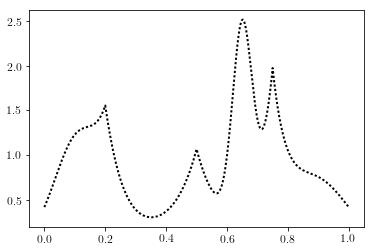

In [34]:
plt.plot(x, df[4], color='black', lw=2, ls=':', label="Gauss Lapl mix Not Dict")


In [35]:
from scipy.integrate import simps
print simps(df[4], np.linspace(0,1,n_pdf))

0.954946359567


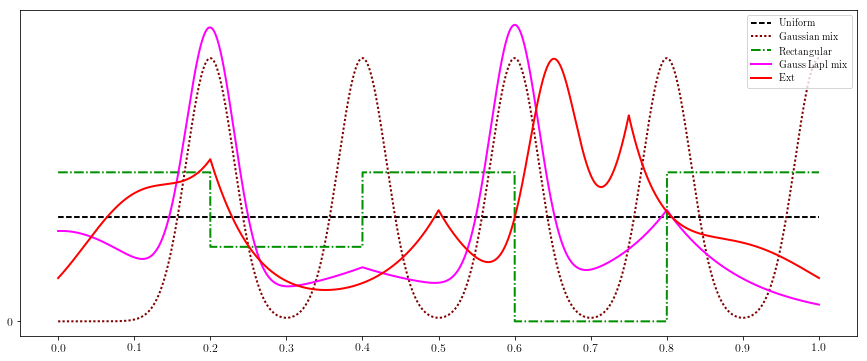

In [36]:
x = np.linspace(0,1,n_pdf)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
fig1, ax1 = plt.subplots(figsize=(15,6))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 8, 3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(x, df[0], color='black', lw=2, ls='--', label="Uniform")
plt.plot(x, df[1], color='#800000', lw=2, ls=':', label="Gaussian mix")
plt.plot(x, df[2], color='#009000', lw=2, ls='-.', label="Rectangular")
plt.plot(x, df[3], color='#ff00ff', lw=2, ls='-', label="Gauss Lapl mix")
plt.plot(x, df[4], color='red', lw=2, ls='-', label="Ext")
plt.legend(loc='upper right')
#plt.title(r'\large{Densities $f^*$ considered}')
#plt.savefig("../../phd-thesis/TeX_files/densities_f_star.png", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

# Tests sur MLE, Adaptive Dantzig and KDE


In [41]:
#choice of sample
X = X_lapl_gauss_not_dict
pdf = pdf_lapl_gauss_not_dict

In [42]:
from algorithm import WeightEstimator

In [43]:
cl = WeightEstimator(densities_dict=densities, select_threshold=10e-8)
cl.fit(X)
estim_weighted_densities=cl.select_densities()
selected_densities_estim, weights_estim = np.array(zip(*estim_weighted_densities))
f_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))


Combined backtracking failed 0 0 90 0 sigma 1


SolverError: Solver 'ECOS' failed. Try another solver.

In [16]:
from adaptiveDantzig import AdaptiveDantzigEstimator
ad= AdaptiveDantzigEstimator(densities=densities)
lambda_dantzig = ad.fit(X)
f_estim_dantzig = np.apply_along_axis(lambda x: lambda_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))
f_estim_dantzig[f_estim_dantzig<0]=1e-10

In [17]:
from scipy.stats import gaussian_kde
from pythonABC.hselect import hsj
kernel = gaussian_kde(X, bw_method=hsj(X))
pdf_kde_hsj = kernel.pdf(np.linspace(0,1,10000))
kernel = gaussian_kde(X)
pdf_kde = kernel.pdf(np.linspace(0,1,10000))

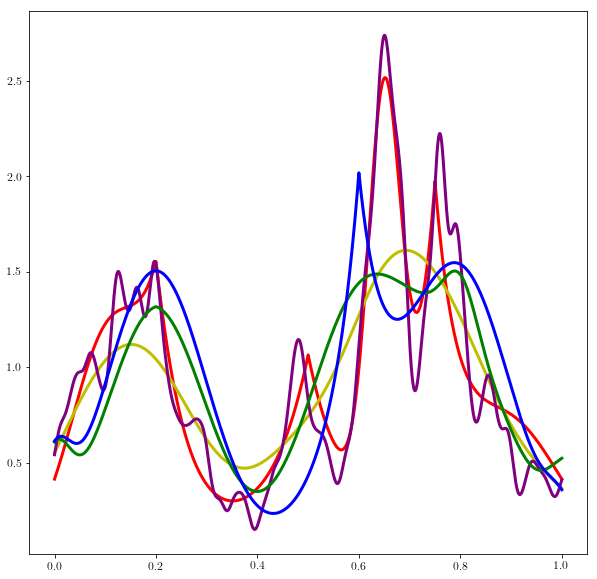

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
#plt.hist(X, bins=100)
x = np.linspace(0,1,10000)
plt.plot(x, pdf, color="r", lw=3)
plt.plot(x, pdf_kde, color="y", lw=3)
plt.plot(x, pdf_kde_hsj, color="purple", lw=3)
plt.plot(x, f_estim, color="g", lw=3)
plt.plot(x, f_estim_dantzig, color="b", lw=3)
plt.show()

In [19]:
from scipy.stats import entropy
#import scipy.integrate as integrate
#integrate.quad(lambda x: x**2, 0, 1)

print "MLE"
print "KL-div:", entropy(pdf, f_estim)
print "L2 norm", 1./n_pdf*np.linalg.norm(pdf-f_estim,axis=0)**2


MLE
KL-div: 0.0598835878313
L2 norm 0.124270099806


In [20]:
print "AD"
print "KL-div:", entropy(pdf, f_estim_dantzig)
print "L2 norm", 1./n_pdf*np.linalg.norm(pdf-f_estim_dantzig,axis=0)**2

AD
KL-div: 0.0935398241438
L2 norm 0.183223115777


In [21]:
print "KDE"
print "KL-div:", entropy(pdf, pdf_kde)
print "L2 norm", 1./n_pdf*np.linalg.norm(pdf-pdf_kde,axis=0)**2

KDE
KL-div: 0.0336090598102
L2 norm 0.0752432649328


In [22]:
print "KDE HSJ"
print "KL-div:", entropy(pdf, pdf_kde_hsj)
print "L2 norm", 1./n_pdf*np.linalg.norm(pdf-pdf_kde_hsj,axis=0)**2

KDE HSJ
KL-div: 0.0217905850004
L2 norm 0.0362137592637
